**Permutation Glass -- Companion notebook  -- November 2017**

In [1]:
%matplotlib inline
import numpy as np
import scipy 
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
import itertools
import copy

import random
import math
import time

import timeit

from numpy import random

### Computing $\langle j \rangle$ for various quenched distributions of $\{ \lambda_j \}$

The partition function for the permutation glass is  

$$
Z_{N}(\{\beta \lambda_i\}) = \sum_{\vec{\theta} \in \text{Sym}(\omega)}\text{exp}\left[\beta  \sum_{i=1}^{N}\lambda_i I_{\theta_i \neq \omega_i} \right] =  \int^{\infty}_{0} ds\, e^{-s} \prod^{N}_{\ell=1}\Big( 1+ (s-1)e^{-\beta\lambda_{\ell}}\Big),
$$

and the average number of incorrectly ordered components can be shown to be

$$
\begin{align}
\langle j \rangle &= N - \frac{1}{Z_{N}(\{\beta \lambda_i\}) }\sum_{k=1}^NZ_{N-1}(\{\beta \lambda_i\}_{i \neq k}),
\end{align}
$$

where $Z_{N-1}(\{\beta \lambda_i\}_{i \neq k})$ is defined by the original partition function with the product taken over the $N-1$ elements of $\{\lambda_i\}$ not including $\lambda_k$.


For the case when there is no disorder, we have 

$$ \langle j \rangle = N - e^{\beta \lambda_0}.$$

----------

#### Parameter Definitions for Distributions 

We consider the gaussian distribution, 

$$
\rho_{0}(\lambda) = \frac{1}{\sqrt{2\pi \sigma_{0}^2}} e^{-(\lambda- \lambda_0)^2 /2\sigma_{0}^2},  
$$

the uniform distribution which has the value 

$$
\rho_{0}(\lambda) = \frac{1}{2\sqrt{3}\sigma_{0}},
$$

for $\lambda_0 - \sigma_{0} \sqrt{3} \leq \lambda \leq \lambda_0 +\sigma_{0} \sqrt{3}$ and is zero otherwise,  

and the symmetric-Bernoulli distribution 

$$
\rho_{0}(\lambda) = q \delta(\lambda - \bar{\lambda}) + (1-q) \delta(\lambda+ \bar{\lambda}),
$$

where $q$ and $\bar{\lambda}$ are related to the mean $\lambda_0$ and standard deviation $\sigma_0$ through 

$$
\bar{\lambda} = \sqrt{\lambda_0^2  +\sigma_0^2}, \qquad q = \frac{1}{2} \left( 1 + \frac{\lambda_0}{\sqrt{\lambda_0^2 + \sigma_0^2}} \right).
$$

In [2]:
'''
The energy cost distribtions for a gaussian, dirac delta (or/Bernoulli), and flat distribution of values 
'''
from scipy.stats import bernoulli

# mean and standard deviation of all distributions
mu, sigma = 1.0, .5 

# number of elements in the vector
nelem = 50

def lbar(mean, std):
    
    return np.sqrt(mean**2 + std**2)

def q(mean, std):
    ''' Gives probability of ybar in bi-dirac distribution'''
    return(0.5*(1 + mean/np.sqrt(mean**2 + std**2)))

# Gaussian Distribution of Values 
lvec_gauss = lambda mu, sigma, nelem: np.random.normal(mu, sigma, nelem)

# Dirac Delta distribution of values
def lvec_dirac(mu, sigma, nelem): 
    
    return np.random.binomial(1, q(mu, sigma), nelem)*2*lbar(mu, sigma)-lbar(mu, sigma)

lvec_dirac = np.vectorize(lvec_dirac)

# Flat Distribution of Values
lvec_flat = lambda mu, sigma, nelem: np.random.uniform(mu - sigma*np.sqrt(3), mu+sigma*np.sqrt(3), nelem)

In [3]:
q(1.0, 0.35)*(1-q(1.0, 0.35))*4*50**2

272.82850779510005

In [4]:
## Test printing energy cost vectors for each distribution of values 

gauss_v = lvec_gauss(mu, sigma, nelem)
dirac_v = lvec_dirac(mu, sigma, nelem)
flat_v = lvec_flat(mu, sigma, nelem)

#print(gauss_v);
#print(dirac_v);
#print(flat_v);

In [5]:
# standard deviation tests 
print("Gaussian Distribution STD:", np.std(gauss_v))
print("Bi-Dirac Distribution STD:", np.std(dirac_v))
print("Flat Distribution STD:", np.std(flat_v))

Gaussian Distribution STD: 0.4882746239815953
Bi-Dirac Distribution STD: 0.5310367218940701
Flat Distribution STD: 0.5076124440853844


In [6]:
# test of q value
q(5.0, 0.0)

1.0

#### Theory definitions of partition function and $\langle j \rangle$

In [7]:
#integrand of partition function 
f = lambda s, T, ls: np.exp(-s)*np.product( 1+ (s-1)*np.exp(-ls/T))

# partition function definition
ZN = lambda T, lvec: scipy.integrate.quad(f, 0, np.inf, args = (T, lvec), limit=1000)[0]

ZN(.76, gauss_v)

7.672539086927296e+40

In [8]:
#product in <j> integrand

def jprod(s,  k , T, ls):
    
    lnew = np.delete(ls, k)
    
    # compute product of all elements except element k
    return(np.product( 1+ (s-1)*np.exp(-lnew/T)))


In [9]:
#Sum of Z_(N-1) functions

def ZN_1sum(T, ls):
    
    N = len(ls)
    
    func = 0
    for k in range(N):
        lnew = np.delete(ls, k)
        func = func + ZN(T, lnew)
        
    return(func)


In [10]:
# test of possibility of evaluation
jprod(1.0, 6, .4, gauss_v)

1.0

In [11]:
# exponential weighted sum of products in <j> integrand

def jint(s, T, ls): 
    
    # number of elements in summation
    N = len(ls)

    #initial value of summ
    summ = 0
    
    for k in range(N): 
        
        summ = summ + np.exp(-ls/T)[k]*jprod(s, k, T, ls)
        
    return(summ*(s-1)*np.exp(-s))

In [12]:
jint(1.0, 1/.50, gauss_v)

0.0

In [13]:
# definition of <j>
avgj =lambda T, lvec: len(lvec)-ZN_1sum(T, lvec)/ZN(T, lvec)

# test of value
avgj(1.0, gauss_v)

46.95965011192725

In [14]:
### function to test low standard deviation values 

# simple zero-disorder order parameter computed from laplace method

def j_funcsimp(y0, N, T):
    
    u = y0/T
    
    if T> y0/np.log(N):
        
        return N - np.exp(y0/T)
    
    else: 
        
        return 0.0
    
j_funcsimp = np.vectorize(j_funcsimp)

#### Theory plots of $\langle j \rangle$ 

In [15]:
# Gaussian Distribution of Values 
lvec_gauss = lambda mu, sigma, nelem: np.random.normal(mu, sigma, nelem)

# Dirac Delta distribution of values
lvec_dirac = lambda mu, sigma, nelem: np.random.binomial(1, q(mu, sigma), nelem)*2*lbar(mu, sigma) - lbar(mu, sigma)

# Flat Distribution of Values
lvec_flat = lambda mu, sigma, nelem: np.random.uniform(mu - sigma*np.sqrt(3), mu+sigma*np.sqrt(3), nelem)

In [16]:
## Code Test: Plot of order parameter versus temperature for very little standard deviation

# number of interacting pairs
nelem = 50

mu, sigma = 1.0, 1.5 # mean and standard deviation
lvec_g_cut = lvec_gauss(mu, 0.35, nelem)
lvec_g_high = lvec_gauss(mu, 1.5, nelem)

# spectrum of temperature values
temp_vals = np.linspace(.01, 1.3, 100)

jvals_g_high = np.zeros(len(temp_vals)) # initialize an empty vector
jvals_g_cut = np.zeros(len(temp_vals)) # initialize an empty vector
for k in range(len(temp_vals)):   # fill vector with values at each temperature 
    jvals_g_high[k] = avgj(temp_vals[k], lvec_g_high);
    jvals_g_cut[k] = avgj(temp_vals[k], lvec_g_cut);

/Users/mobolajiwilliams/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/mobolajiwilliams/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  """
/Users/mobolajiwilliams/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


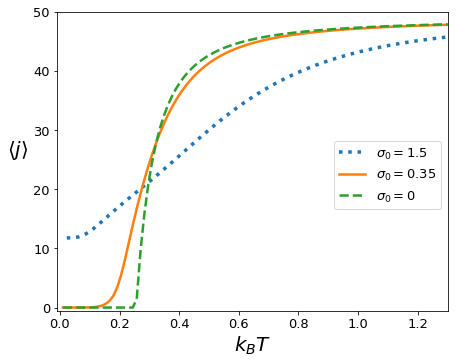

In [17]:
plt.figure(figsize = (7,5.5))

#plots 
plt.plot(temp_vals, jvals_g_high, label = r'$\sigma_0 = 1.5$', linestyle = ':', linewidth = 3.5) # plot partition function for distribution of values 
plt.plot(temp_vals, jvals_g_cut, label = r'$\sigma_0 = 0.35$', linewidth = 2.5) # plot partition function for  distribution of values 
plt.plot(temp_vals, j_funcsimp(mu, nelem, temp_vals), label = r'$\sigma_0 = 0$', linewidth = 2.5, linestyle = 'dashed') # plot partition function with energy cost given by mean

## Plot formatting
plt.xlabel(r'$k_B T$', fontsize = 20)
plt.xlim([-0.01,1.3])
plt.ylim([-.5,50])
plt.ylabel(r'$\langle j \rangle$', fontsize = 20, rotation=0)
ax = plt.gca()
ax.yaxis.set_label_coords(-0.1,.5)
plt.tick_params(axis='both', which='major', labelsize=13)
plt.legend(bbox_to_anchor = (1.0,.59), fontsize = 13)

plt.show()

In [18]:
## Code Test: Plot of order parameter versus temperature for moderate and large standard deviation
# number of interacting pairs
nelem = 50 

mu = 1.0 # mean and standard deviation
lvec_d_cut = lvec_dirac(mu, .35, nelem)
lvec_d_high = lvec_dirac(mu, 1.5, nelem)

# spectrum of temperature values
temp_vals = np.linspace(.01, 1.3, 100)

jvals_d_cut = np.zeros(len(temp_vals)) # initialize an empty vector
jvals_d_high = np.zeros(len(temp_vals)) # initialize an empty vector
for k in range(len(temp_vals)):   # fill vector with values at each temperature
    jvals_d_cut[k] = avgj(temp_vals[k], lvec_d_cut)
    jvals_d_high[k] = avgj(temp_vals[k], lvec_d_high)


/Users/mobolajiwilliams/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  """


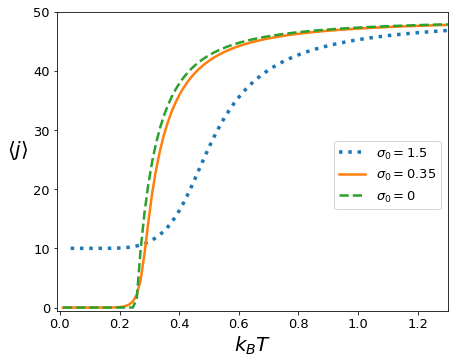

In [19]:
plt.figure(figsize = (7,5.5))


plt.plot(temp_vals, jvals_d_high, label = r'$\sigma_0 = 1.5$', linestyle = ':', linewidth = 3.5) # plot partition function for distribution of values 
plt.plot(temp_vals, jvals_d_cut, label = r'$\sigma_0 = 0.35$', linewidth = 2.5) # plot partition function for  distribution of values 
plt.plot(temp_vals, j_funcsimp(mu, nelem, temp_vals), label = r'$\sigma_0 = 0$', linewidth = 2.5, linestyle = 'dashed') # plot partition function with energy cost given by mean

## Plot formatting
plt.xlabel(r'$k_B T$', fontsize = 20)
plt.xlim([-0.01,1.3])
plt.ylim([-.5,50])
plt.ylabel(r'$\langle j \rangle$', fontsize = 20, rotation=0)
ax = plt.gca()
ax.yaxis.set_label_coords(-0.1,.5)
plt.tick_params(axis='both', which='major', labelsize=13)
plt.legend(bbox_to_anchor = (1.0,.59), fontsize = 13)

plt.show()

In [20]:
## Code Test: Plot of order parameter versus temperature for moderate and large standard deviation
# number of interacting pairs
nelem = 50 

mu, sigma = 1.0, .75 # mean and standard deviation
lvec_f_cut = lvec_flat(mu, .35, nelem)
lvec_f_high = lvec_flat(mu, 1.5, nelem)

# spectrum of temperature values
temp_vals = np.linspace(.01, 1.3, 100)

jvals_f_cut = np.zeros(len(temp_vals)) # initialize an empty vector
jvals_f_high = np.zeros(len(temp_vals)) # initialize an empty vector
for k in range(len(temp_vals)):   # fill vector with values at each temperature
    jvals_f_cut[k] = avgj(temp_vals[k], lvec_f_cut)
    jvals_f_high[k] = avgj(temp_vals[k], lvec_f_high)

/Users/mobolajiwilliams/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  """


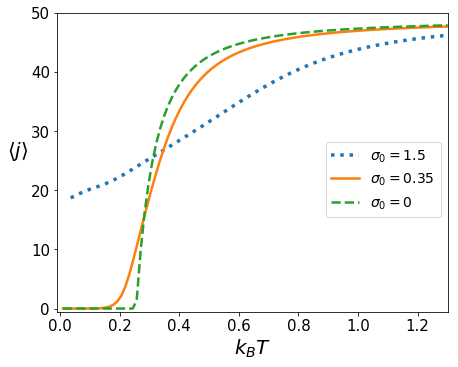

In [21]:
plt.figure(figsize = (7,5.5))

plt.plot(temp_vals, jvals_f_high, label = r'$\sigma_0 = 1.5$', linestyle = ':', linewidth = 3.5) # plot partition function for distribution of values 
plt.plot(temp_vals, jvals_f_cut, label = r'$\sigma_0 = 0.35$', linewidth = 2.5) # plot partition function for  distribution of values 
plt.plot(temp_vals, j_funcsimp(mu, nelem, temp_vals), label = r'$\sigma_0 = 0$', linewidth = 2.5, linestyle = 'dashed') # plot partition function with energy cost given by mean


## Plot formatting
plt.xlabel(r'$k_B T$', fontsize = 20)
plt.xlim([-0.01,1.3])
plt.ylim([-.5,50])
plt.ylabel(r'$\langle j \rangle$', fontsize = 20, rotation=0)
ax = plt.gca()
ax.yaxis.set_label_coords(-0.1,.5)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(bbox_to_anchor = (1.0,.59), fontsize = 14)

plt.show()

#### Simulation and Theory plots of $\langle j \rangle$

In [22]:
# List of favorable contacts 
# order doesn't matter so we include reversed elements as well 

Ncomp = 50

omega0 = [0]*Ncomp
for k in range(Ncomp):
    omega0[k] = k

In [23]:
# checking values of omega
print(omega0)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]


In [24]:
## Hamiltonian function 

def Ham(lvec, ls, Ncomp):
    
    N = int(Ncomp)
    energy = 0
    
    for k in range(N):
        
        # there is an energy cost if ls[k] doesn't equal omega0[k]
        
        if ls[k] != omega0[k]:       
            energy = energy + lvec[k]
            
    return energy   

In [25]:
## transition operator
def trans(init_ls):
    
    i1 = int(random.choice(range(Ncomp)))
    i2 = int(random.choice(range(Ncomp)))

    ## new omega vector 
    fin_ls = copy.deepcopy(init_ls)
    fin_ls[i2] = init_ls[i1]
    fin_ls[i1] = init_ls[i2]
    
    return(fin_ls)

In [26]:
## Defining Boltzmann Weight
def Boltz(lvec, ls, T, Ncomp):
            
    return np.exp(-Ham(lvec, ls, Ncomp)*1.0/T)

In [27]:
## number of favorable contacts; normalized
def j(ls, Ncomp):
    
    N = int(Ncomp)
    num = 0
    
    for k in range(N):
        
        if ls[k] != omega0[k]:
            num = num+1
            
    return num

In [28]:
### Metropolis Monte Carlo Algorithm 

## loads uniform random sampling 
runif = np.random.rand

def met_permglass(n_iter, initial_state, lamb, temp, Ncomp):
    '''
    #################################################################
    # function to sample using Metropolis 
    #  
    # n_iter:  number of iterations
    # initial_state: initial state for the start position for our chain
    # gamma: energy cost for incorrect component
    # temp: temperature 
    ##################################################################
    '''
    # Initialize trace for state values
    state_vals = [0]*(n_iter+1)
    
    # Set initial values
    state_vals[0] = initial_state
        
    #sets current log-probability
    #current_prob = prob_d(T[0], lamb) 
    log_current_prob = np.log(Boltz(lamb, state_vals[0], temp, Ncomp))
        
    # Initialize acceptance counts
    # We can use this to tune our step size
    accepted = 0
    
    for i in range(n_iter):
    
        # get current permutation
        current_state = state_vals[i]
        
        # proposed new permutation; generated from random integer sampling
        new_state = trans(current_state)
        
        # Calculate posterior log-probability with proposed value
        log_proposed_prob = np.log(Boltz(lamb, new_state, temp, Ncomp)) 

        # Log-acceptance rate
        log_alpha = log_proposed_prob- log_current_prob

        # Sample a uniform random variate
        u = runif()

        # Test proposed value
        if np.log(u) < log_alpha:
            # Accept
            state_vals[i+1] = new_state
            log_current_prob = log_proposed_prob
            accepted += 1
        else:
            # Stay put
            state_vals[i+1] = state_vals[i]

    # return our samples and the number of accepted steps
    return state_vals, accepted

In [29]:
## average number of incorrect contacts across all states in ensemble

## we start far from the beginning of the chain to ensure that it
## has reached "equilibrium"

def avg_j(state_vals, Nmc, Ncomp):
    
    length = int(Nmc/50)
    
    ls = [0]*length
    ls = np.array(ls)
    for k in range(length):
        ls[k] = j(state_vals[Nmc-length+k], Ncomp)
    
    
    return(np.mean(ls))

In [30]:
## standard deviation of number of incorrect components across all states in ensemble

## we start far from the beginning of the chain to ensure that it
## has reached "equilibrium"

def std_j(state_vals, Nmc, Ncomp):
    
    length = int(Nmc/50)
    
    ls = [0]*length
    ls = np.array(ls)
    for k in range(length):
        ls[k] = j(state_vals[Nmc-length+k], Ncomp)
    
    
    return(np.std(ls))

##### Predicted (Inverse) Transition Temperatures

For gaussian distribution: 

$$
\beta_c = \frac{\lambda_0}{\sigma_{0}^2} \left( 1 - \sqrt{1 - \frac{2\sigma_{0}^2}{\lambda_{0}^2} \ln N}\,\right).
$$

For uniform distribution: 
$$
\beta_c \simeq \frac{1}{\lambda_0 - \sigma_0 \sqrt{3}} W_{0} \left(\frac{N}{2\sigma_{0}\sqrt{3}}(\lambda_0 - \sigma_0 \sqrt{3}) \right),
$$
where $W_0$ is the principal branch of the Lambert W function, and this is an approximate result valid for large $\sigma_0$. 

For symmetric-Bernoulli (or bi-Dirac) distribution: 
$$
\beta_c \bar{\lambda} = \ln \left[ \frac{1}{2N(1-q)} \left( 1 - \sqrt{1- 4N^2 q (1-q)}\right) \right].
$$


In [31]:
### Gaussian ###
betac_gauss = lambda avg_l, std_l, N: (avg_l/(std_l)**2)*(1- np.sqrt(1- 2.0*(std_l**2/(avg_l**2))*np.log(N)  ))


### Uniform (for large sigma) ### 
betac_flat = lambda avg_l, std_l, N: np.real(1.0/(avg_l-np.sqrt(3)*std_l)*scipy.special.lambertw(N*(avg_l-np.sqrt(3)*std_l)/(2*std_l*np.sqrt(3)) ))


### Dirac ###
betac_dirac = lambda avg_l, std_l, N: (1.0/np.sqrt(avg_l**2 + std_l**2))*np.log((1-avg_l/np.sqrt(std_l**2+avg_l**2))**(-1)*(1-np.sqrt(1-N**2*std_l**2/(std_l**2+avg_l**2 )))/N)

------

**Aside:**

For uniform distribution, the exact transition temperature is found by solving 

$$
-\beta_c \lambda_0+\ln \left[\frac{\sinh(\beta_c \sigma_{0}\sqrt{3})}{\beta_c \sigma_{0}\sqrt{3}}\right] + \ln N = 0.  $$

In [32]:
'''
Equation solver for finding exact temperature for the uniform distribution
'''

## Constrain function ##
func_flat = lambda beta_c, avg_l, std_l, N: beta_c*avg_l- np.log(N*np.sinh(beta_c*std_l*np.sqrt(3))/(beta_c*std_l*np.sqrt(3)))

## Solving the constraint for beta ##
def flat_solver2(mean_l, sig_l, N):
    
    func_reduced = lambda beta_c: func_flat(beta_c, mean_l, sig_l, N)
    
    beta_guess = np.log(N)/mean_l
    
    beta_soln = fsolve(func_reduced, beta_guess)
    
    return(beta_soln[0])

flat_solver2 = np.vectorize(flat_solver2)

In [33]:
# checking relative error of approximation for intermediate variance

np.abs(flat_solver2(1.0, .35, 50) - betac_flat(1.0, .35, 50))/flat_solver2(1.0, .35, 50)

0.0005716911368662681

---------

#### Gaussian Simulation

In [34]:
## Generate lf for each temperature from .03 to 2.0 in npoints steps


# number of samples
Nmc = 20000

# number of joining contacts
Ncomp = 50
## zeroth state function 
omega0 = [0]*Ncomp
for k in range(Ncomp):
    omega0[k] = k

npoints = 30
temp_vals = np.linspace(.01, 1.3, npoints).tolist()
j_vals_g = [0]*npoints
std_vals_g = [0]*npoints
for k in range(npoints):
    # make copy of list 
    omega_cpy = copy.deepcopy(omega0)

    # metroplois generator
    states_list, accepted = met_permglass(Nmc, omega_cpy, lvec_g_cut, temp_vals[k], Ncomp)
    
    j_vals_g[k] = avg_j(states_list, Nmc, Ncomp)
    std_vals_g[k] = std_j(states_list, Nmc, Ncomp)

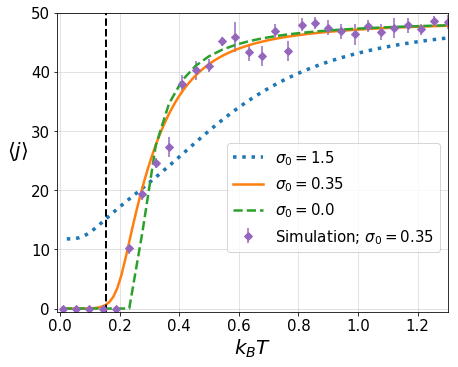

In [35]:
plt.figure(figsize = (7,5.5))

# spectrum of temperature values
temp_vals100 = np.linspace(.01, 1.3, 100)

# plots 
plt.plot(temp_vals100, jvals_g_high, label = r'$\sigma_0 = 1.5$', linestyle = ':', linewidth = 3.5) # plot partition function for distribution of values 
plt.plot(temp_vals100, jvals_g_cut, label = r'$\sigma_0 = 0.35$', linewidth = 2.5) # plot partition function for  distribution of values 
plt.plot(temp_vals, j_funcsimp(mu, nelem, temp_vals), label = r'$\sigma_0 = 0.0$', linewidth = 2.5, linestyle = 'dashed') # plot partition function with energy cost given by mean
plt.axvline(x=1/betac_gauss(1.0, .35, nelem), color = 'k', linestyle='dashed', linewidth = 2.0)
plt.errorbar(temp_vals,j_vals_g, yerr=std_vals_g, fmt='C4D',label = r'Simulation; $\sigma_0 = 0.35$', markersize = 5.5 )

# plot formatting
plt.xlabel(r'$k_B T$', fontsize = 20)
plt.xlim([-0.01,1.3])
plt.ylim([-.5,50])
plt.ylabel(r'$\langle j \rangle$', fontsize = 20, rotation=0)
ax = plt.gca()
ax.yaxis.set_label_coords(-0.1,.5)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(bbox_to_anchor = (1.0,.59), fontsize = 15)
plt.grid(alpha = 0.45)

plt.savefig('avg_j_gauss_N50.png',bbox_inches='tight')

plt.show()

#### Symmetric Bernoulli

In [36]:
## Generate lf for each temperature from .03 to 2.0 in npoints steps


# number of samples
Nmc = 20000

# number of joining contacts
Ncomp = 50
## zeroth state function 
omega0 = [0]*Ncomp
for k in range(Ncomp):
    omega0[k] = k

npoints = 30
temp_vals = np.linspace(.01, 1.3, npoints).tolist()
j_vals_d = [0]*npoints
std_vals_d = [0]*npoints
for k in range(npoints):
    # make copy of list 
    omega_cpy = copy.deepcopy(omega0)

    # metroplois generator
    states_list, accepted = met_permglass(Nmc, omega_cpy, lvec_d_cut, temp_vals[k], Ncomp)
    
    j_vals_d[k] = avg_j(states_list, Nmc, Ncomp)
    std_vals_d[k] = std_j(states_list, Nmc, Ncomp)

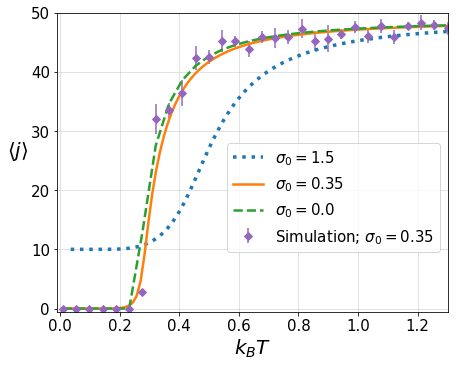

In [37]:
plt.figure(figsize = (7,5.5))

# spectrum of temperature values
temp_vals100 = np.linspace(.01, 1.3, 100)

# plots 
plt.plot(temp_vals100, jvals_d_high, label = r'$\sigma_0 = 1.5$', linestyle = ':', linewidth = 3.5) # plot partition function for distribution of values 
plt.plot(temp_vals100, jvals_d_cut, label = r'$\sigma_0 = 0.35$', linewidth = 2.5) # plot partition function for  distribution of values 
plt.plot(temp_vals, j_funcsimp(mu, nelem, temp_vals), label = r'$\sigma_0 = 0.0$', linewidth = 2.5, linestyle = 'dashed') # plot partition function with energy cost given by mean
plt.errorbar(temp_vals,j_vals_d, yerr=std_vals_d, fmt='C4D',label = r'Simulation; $\sigma_0 = 0.35$', markersize = 5.5 )

# plot formatting
plt.xlabel(r'$k_B T$', fontsize = 20)
plt.xlim([-0.01,1.3])
plt.ylim([-.5,50])
plt.ylabel(r'$\langle j \rangle$', fontsize = 20, rotation=0)
ax = plt.gca()
ax.yaxis.set_label_coords(-0.1,.5)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(bbox_to_anchor = (1.0,.59), fontsize = 15)
plt.grid(alpha = 0.45)

plt.savefig('avg_j_dirac_N50.png',bbox_inches='tight')

plt.show()

#### Uniform Distribution

In [38]:
## Generate lf for each temperature from .03 to 2.0 in npoints steps


# number of samples
Nmc = 20000

# number of joining contacts
Ncomp = 50
## zeroth state function 
omega0 = [0]*Ncomp
for k in range(Ncomp):
    omega0[k] = k

npoints = 30
temp_vals = np.linspace(.01, 1.3, npoints).tolist()
j_vals_f = [0]*npoints
std_vals_f = [0]*npoints
for k in range(npoints):
    # make copy of list 
    omega_cpy = copy.deepcopy(omega0)

    # metroplois generator
    states_list, accepted = met_permglass(Nmc, omega_cpy, lvec_f_cut, temp_vals[k], Ncomp)
    
    j_vals_f[k] = avg_j(states_list, Nmc, Ncomp)
    std_vals_f[k] = std_j(states_list, Nmc, Ncomp)

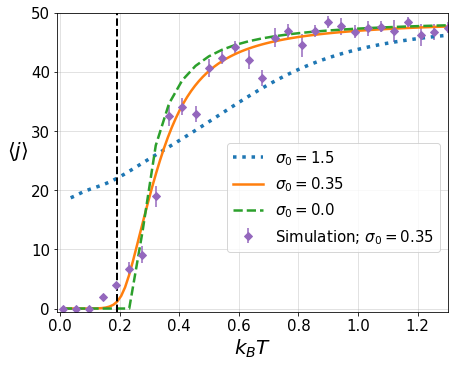

In [39]:
#matplotlib.style.use('default')
plt.figure(figsize = (7,5.5))

# spectrum of temperature values
temp_vals100 = np.linspace(.01, 1.3, 100)

# plots 
plt.plot(temp_vals100, jvals_f_high, label = r'$\sigma_0 = 1.5$', linestyle = ':', linewidth = 3.5) # plot partition function for distribution of values 
plt.plot(temp_vals100, jvals_f_cut, label = r'$\sigma_0 = 0.35$', linewidth = 2.5) # plot partition function for  distribution of values 
plt.plot(temp_vals, j_funcsimp(mu, nelem, temp_vals), label = r'$\sigma_0 = 0.0$', linewidth = 2.5, linestyle = 'dashed') # plot partition function with energy cost given by mean
plt.axvline(x=1/betac_flat(1.0, 0.35, nelem), color = 'k', linestyle='dashed', linewidth = 2.0)
plt.errorbar(temp_vals,j_vals_f, yerr=std_vals_f, fmt='C4D',label = r'Simulation; $\sigma_0 = 0.35$', markersize = 5.5 )

# plot formatting
plt.xlabel(r'$k_B T$', fontsize = 20)
plt.xlim([-0.01,1.3])
plt.ylim([-.5,50])
plt.ylabel(r'$\langle j \rangle$', fontsize = 20, rotation=0)
ax = plt.gca()
ax.yaxis.set_label_coords(-0.1,.5)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(bbox_to_anchor = (1.0,.59), fontsize = 15)
plt.grid(alpha = 0.45)

plt.savefig('avg_j_flat_N50.png',bbox_inches='tight')

plt.show()

### Plot of transition temperatures as funcitons of $\sigma_0/\lambda_0$

/Users/mobolajiwilliams/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  
/Users/mobolajiwilliams/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in sqrt
  # Remove the CWD from sys.path while we load stuff.


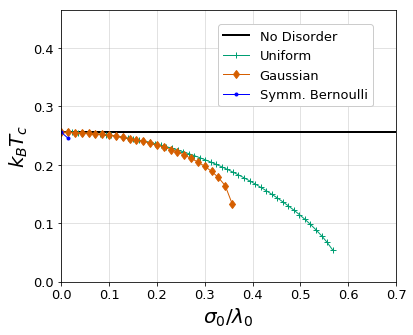

In [43]:
# parameter choices
mean_l = 1.0
Nval = 50
sig_final = .7

# domain of values for standard deviation
sigs = np.linspace(0.000005, sig_final, 50)

# domain of values for standard deviation for the uniform distribution
sigs_flat = np.linspace(0.000005, mean_l/(np.sqrt(3))-0.01, 50)

# create figure
fig = plt.figure(figsize=(6,5))
    
plt.axhline(mean_l/np.log(Nval), color = 'k', linewidth=2, label = 'No Disorder')
plt.plot(sigs_flat, 1.0/(flat_solver2(mean_l, sigs_flat, Nval)), color = (0, 158./255, 115./255), marker = '+', linewidth=1, label = 'Uniform')
plt.plot(sigs, 1.0/(betac_gauss(mean_l, sigs, Nval)), color = (213./255, 94./255, 0) ,marker = 'd', linewidth=1, label = 'Gaussian')
plt.plot(sigs, 1.0/(betac_dirac(mean_l, sigs, Nval)), 'b.-', linewidth=1, label = 'Symm. Bernoulli')

plt.ylim([0,mean_l/np.log(Nval)+.21])
plt.xlim([0, sig_final])
plt.xlabel(r'$\sigma_{0}/\lambda_0$', fontsize=20)
plt.ylabel(r'$k_B T_c$', fontsize=20)
leg = plt.legend(bbox_to_anchor=(.95, .97), fontsize=13)
leg.get_frame().set_alpha(1.0)
plt.grid(alpha = 0.45)

# tick parameters
plt.tick_params(axis='both', which='major', labelsize=13)

plt.savefig('N50Tc_disorder.png',bbox_inches='tight')
#dpi=fig.dpi ensures the displayed and saved figure have the same margins

plt.show()

### Log-log plots of critical probabilities

The critical probabilities for the various distributions are 

\begin{align}
P^{\text{uniform}}_{\,\lambda<0} &\, \leq \,\frac{1}{Ne}  \\
P^{\text{gauss}}_{\,\lambda<0} \,& \lesssim  \,\frac{1}{2 N \sqrt{\pi \ln N}} \\
P^{\text{bernoulli}}_{\,\lambda<0} \,& \lesssim \,\frac{1}{4N^2}.
\end{align}

The general result is 
$$
P_{\, \lambda<0} < \frac{1}{N}
$$

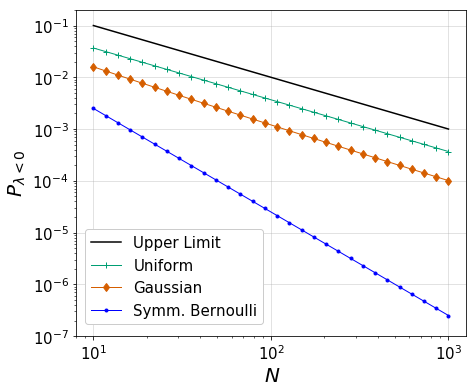

In [41]:
## log x plot of probability vs N ##

# Plot it
Nf = 3 # largest value is 10^3
Ns = np.logspace(1, Nf, 30)

# create figure
plt.figure(figsize=(7,6))

plt.loglog(Ns, 1.0/Ns, 'k-', linewidth=1.5, label = 'Upper Limit',  basex = 10.0)
plt.loglog(Ns, 1.0/(Ns*2.718), color = (0, 158./255, 115./255), linewidth=1, marker = '+', label = 'Uniform', basex = 10.0)
plt.loglog(Ns, 0.5*(1-scipy.special.erf(np.sqrt(np.log(Ns)))), color = (213./255, 94./255, 0),marker = 'd', linewidth=1, label = 'Gaussian',  basex = 10.0)
plt.loglog(Ns, 0.5*(1- np.sqrt(1-1/Ns**2)), 'b.-', linewidth=1, label = 'Symm. Bernoulli', basex = 10.0)

plt.ylim([.0000001, .2])
#plt.xlim([1, Nf])
plt.xlabel(r'$\,N$', fontsize=20)
plt.ylabel(r'$P_{\lambda<0}$', fontsize=20)
leg = plt.legend(bbox_to_anchor=(.5, .35), fontsize=15)
leg.get_frame().set_alpha(1.0)
plt.grid(alpha = 0.45)

# tick parameters
plt.tick_params(axis='both', which='major', labelsize=15)

# plt.savefig('loglogprob_plot.png', dpi=fig.dpi,bbox_inches='tight')
#dpi=fig.dpi ensures the displayed and saved figure have the same margins

plt.show()